### Implementa una red completamente conectada para la tarea de clasificacion de imagenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguientes especificaciones

* Explora con diferentes numero de neuronas, capas, funciones de activacion e hiperparametros
* Discutir los resultados con las distintas configuraciones

In [1]:
#Importamos librerias utiles
#deep learning
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizer
import torchvision.datasets.utils as tutils
import torchvision.datasets as DataSets
from torchvision import transforms
#matrices y matematicas
import numpy as np
# tomar n elementos de una secuencia
from itertools import islice as take
#imagenes
from matplotlib import pyplot as plt

In [2]:
#para usar la GPU
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"

device = torch.device(dev)
print(device)

cuda:0


In [3]:
#cargamos el dataset de fashion-MNIST de train
fmnist_train = DataSets.FashionMNIST(root='\FashionMNIST',train=True, download=True, transform = np.array)
##cargamos el dataset de fashion-MNIST de test
fmnist_test = DataSets.FashionMNIST(root='\FashionMNIST',train=False, download=True, transform = np.array)

In [4]:
#para verificar imprimimos la info de ambos datasets
print(fmnist_train)
print('#'*50)
print(fmnist_test)
# Sembramos semillas para reproducibilidad
np.random.seed(2020)
torch.manual_seed(2020)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: \FashionMNIST
    Split: Train
    StandardTransform
Transform: <built-in function array>
##################################################
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: \FashionMNIST
    Split: Test
    StandardTransform
Transform: <built-in function array>


In [5]:
#creamos una funcion para ver n imagenes con i columnas y j filas
def muestraImagenes(columnas,filas,fmnist):
    #crea dos listas vacias que contendran las imagenes y las etiquetas respectivamente
    images, labels = [], []
    #itera sobre el producto de las filas con las columnas es decir el total de imagenes
    for image in range(int(columnas*filas)):
        #si el argumento es train
        if fmnist == 'train':
            #toma las imagenes y etiquetas del dataset train
            im , lab = fmnist_train[image]
        #si el argumento no es train
        else:
            #toma las imagenes y etiquetas del dataset test
            im , lab = fmnist_test[image]
        #has append a la lista de imagenes con la imagen actual
        images.append(im)
        #has append a la lista de etiquetas con la etiqueta actual
        labels.append(str(lab))
        #convierte a string las etiquetas
        titles = [str(y) for y in labels]
    #define una variable dummy que sirve para iterar sobre todas las imagenes
    contador = 0
    #define el array de imagenes con tamaño de 10x10
    f, axarr = plt.subplots(filas,columnas, figsize=(10,10))
    #itera sobre las filas del array de imagenes
    for fila in range(filas):
        #itera sobre las columnas del array de imagenes
        for columna in range(columnas):
            #muestra la imagen en la posicion de la variable dummy
            axarr[fila,columna].imshow(images[contador],cmap='gray')
            #muestra sobre esa imagen un titulo que corresponde a su etiqueta
            axarr[fila,columna].set_title('Label: {0}'.format(titles[contador]))
            #quita los numeros de los ejes
            axarr[fila,columna].set_xticklabels([])
            axarr[fila,columna].set_yticklabels([])
            #suma uno a la variable dummy
            contador += 1
    #muestra el array de imagenes
    plt.show()

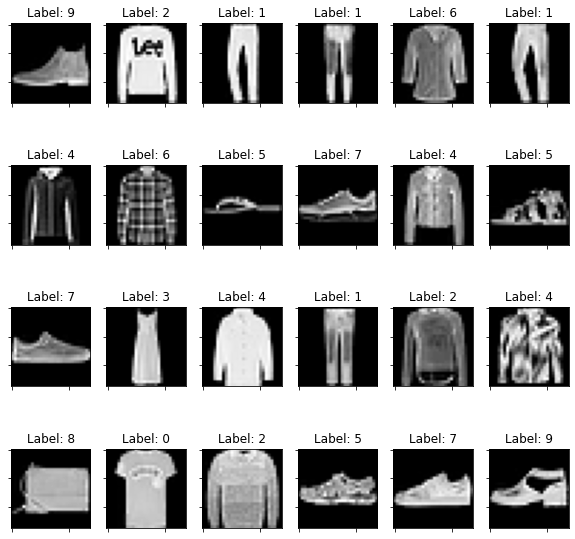

In [6]:
muestraImagenes(columnas=6,filas=4,fmnist='test')

### Preprcesamiento de los datos

In [7]:
#volvemos a cargar ambos datasets pero ahora como tensores de torch
#cargamos el dataset de fashion-MNIST de train
fmnist_train = DataSets.FashionMNIST(root='\FashionMNIST',train=True, download=True, transform = transforms.Compose([
    transforms.ToTensor()]))
##cargamos el dataset de fashion-MNIST de test
fmnist_test = DataSets.FashionMNIST(root='\FashionMNIST',train=False, download=True, transform = transforms.Compose([
    transforms.ToTensor()]))

#ahora vamos a calcular la media y desciacion estandar de cada data set
#esto para normalizar las imagenes ya que las redes neuronales "funcionan" mejor
#con pixeles con valores entre 0 y 1
#Esto se va a hacer de la forma facil, esta forma facil solo es posible para datasets que pueden cargarse
#en memoria de acuerdo a https://deeplizard.com/learn/video/lu7TCu7HeYc

#instanciamos un DataLoader para el dataset de train
loader_train = DataLoader(fmnist_train, batch_size=len(fmnist_train), num_workers=1)
#ponemos en memoria cada imagen usando el iterador y el next de torch
data_train = next(iter(loader_train))
#calculamos la media y la desviacion estandar
mean_train, std_train = data_train[0].mean(), data_train[0].std()
#imprimimos valores
print('La media del dataset de train es {0} y la desviacion estandar es {1}'.format(mean_train, std_train))

La media del dataset de train es 0.2860347330570221 y la desviacion estandar es 0.3530242443084717


In [8]:
#instanciamos un DataLoader para el dataset de train
loader_test = DataLoader(fmnist_test, batch_size=len(fmnist_test), num_workers=1)
#ponemos en memoria cada imagen usando el iterador y el next de torch
data_test = next(iter(loader_test))
#calculamos la media y la desviacion estandar
mean_test, std_test = data_test[0].mean(), data_test[0].std()
#imprimimos valores
print('La media del dataset de test es {0} y la desviacion estandar es {1}'.format(mean_test, std_test))

La media del dataset de test es 0.28684961795806885 y la desviacion estandar es 0.3524441719055176


In [9]:
#recargamos los datasets para poder aplicarles la transformacion de estandarizacion
#train
fmnist_train = DataSets.FashionMNIST(root='\FashionMNIST',train=True, download=True, transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean_train,std_train)]))
#test
fmnist_test = DataSets.FashionMNIST(root='\FashionMNIST',train=False, download=True, transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean_test,std_test)]))

In [10]:
#reutilizamos nuestros dataloaders
#usamos un tamaño de lote de 512 ya que son bastantes imagenes
#(y tenemos poder computacional :v)
loader_train = DataLoader(fmnist_train, batch_size=256, shuffle = True)
loader_test = DataLoader(fmnist_test, batch_size=256, shuffle = True)

#imprimimos un lote de imagenes de train
for x, y in take(loader_train, 1):
    print(f'El shape de un lote de imagenes de entrenamiento es {x.shape} y su tipo es {x.dtype}')
    print(f'El shape de un lote de etiquetas entrenamiento es{y.shape} y su tipo es {y.dtype}')

El shape de un lote de imagenes de entrenamiento es torch.Size([256, 1, 28, 28]) y su tipo es torch.float32
El shape de un lote de etiquetas entrenamiento estorch.Size([256]) y su tipo es torch.int64


### Funcion que entrena

In [20]:
#creamos la funcion que entrena
def entrename(X,Y,modelo,epocas,learningRate):
    #sembramos semilla aleatoria para reproducibilidad
    torch.manual_seed(2020)
    #funcion para resetear los pesos, esta funcion es util para reproducibilidad de todos los modelos
    #dado que vamos a usar el mismo modelo pero con diferentes hiperparametros es necesario resetear los pesos
    def weight_reset(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.reset_parameters()
    #se resetean los pesos con la funcion anterior
    modelo.apply(weight_reset)
    #llamamos al algoritmo del descenso del gradiente
    optimizador = optimizer.SGD(modelo.parameters(), lr = learningRate)
    #creamos una lista que tendra el historico por epoca de las perdidas y los accuracys
    lossHistory = []
    accuracyHistory = []
    #iteramos sobre las epocas
    for epoca in range(epocas):
        #iteramos sobre todos los datos
        for x , y in X:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            #vaciamos los gradientes
            optimizador.zero_grad()
            #calculamos los logits
            logits = modelo(x)
            #calculamos la perdida
            loss = func.cross_entropy(logits, y)
            #hacemos retropropagacion
            loss.backward()
            #actualizamos parametros
            optimizador.step()
        #una vez que termino una epoca podemos hacer inferencia
        #evitamos que se modifiquen los parametros aprendidos por una epoca
        with torch.no_grad():
            #seteamos el modelo en modo evaluacion
            modelo.eval()
            #creamos dos listas que tendran el historico por una epoca de las perdidas y los accuracy's
            perdidas, accuracys = [], []
            #validamos lo aprendido en la epoca
            for x, y in take(Y, 5):
                x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
                #calculamos los logits
                logits = modelo(x)
                #calculamos las probabilidades de etiqueta
                proba = func.softmax(logits, 1)
                #tomamos el valor maximo de las probabilidades y asignamos a esa probabilidad la clase
                prediccion = torch.argmax(proba,1)
                #calculamos la perdida
                loss = func.cross_entropy(logits, y)
                #calculamos la accuracy
                acc = (y == prediccion).type(torch.float32).mean()
                #hacemos un apend a los historicos con la perdida y accuracy que acabamos de calcular
                perdidas.append(loss.item()*100)
                accuracys.append(acc.item()*100)
            
            #imprimimos la perdida y el acurracy que acabamos de calcular (una epoca)
            loss = np.mean(perdidas)
            acc = np.mean(accuracys)
            print('Epoca: {0}   Perdida:{1}   Accuracy:{2}'.format(epoca, loss, acc))
            #agregamos al historial de perdidas
            lossHistory.append(loss)
            #agregamos al historial de accuracys
            accuracyHistory.append(acc)
            #regresamos al modo entrenamiento
            modelo.train()
    return lossHistory, accuracyHistory 

In [22]:
## Creamos una funcion que grafica los datos:
def grafica(perdidas, accurac):
    plt.plot(np.arange(len(perdidas)), perdidas, 'o', label='Perdida', color = 'pink')
    plt.plot(np.arange(len(accurac)), accurac, 'o', label='Accuracy', color = 'red')
    plt.legend()
    plt.xlabel('Epocas')
    plt.ylabel('Perdida/Accuracy')
    plt.grid(True)
    plt.show()

## Definicion de arquitecturas
Realizaremos tres arquitecturas mas la que sabemos que es funcional para un perceptron multicapa para clasificacion de imagenes y compararemos sus resultados

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [28]:
#modelo estandar reshape -> fully conected -> ReLU -> fully conected -> softmax
class MLP(nn.Module):
    #instanciador
    def __init__(self, out):
        #llamamos a la clase padre
        super(MLP, self).__init__()
        #definimos el tamano de las capas de ante mano sabemos que es de 1*28*28
        self.I = 1* 28 * 28
        #definimos los nombres de las dos capas fully conected
        FC1, FC2 = out, 10
        #definimos las capas
        self.cls = nn.Sequential(
            #primer fully conected toma n vectores de 1x28x28 y transformalos a n vectores de 128
            nn.Linear(self.I, FC1),
            #funcion de activacion relu
            nn.ReLU(),
            # segunda fully conected entrada de 128 y salida de 10 (clases)
            nn.Linear(FC1, FC2)
        )
        
    #inferencia
    def forward(self, x):
        #hacemos reshape de las imagenes (1,28,28) a (1*28*28)
        x = x.view(-1, self.I)
        #inferencia
        x = self.cls(x)
        return x        

In [13]:
#instanciamos el modelo
estandar = MLP().to(device, non_blocking=True)
print(estandar)
#estandar.to(device)
#prueba de la arquitectura
x = torch.zeros(1,1,28,28)
x = x.to(device)
y = estandar(x)
print(y.shape)

MLP(
  (cls): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
torch.Size([1, 10])


In [21]:
ww, ss = entrename(X = loader_train, Y = loader_test, modelo = estandar, epocas = 20, learningRate = 1e-3)

Epoca: 0   Perdida:174.8369598388672   Accuracy:54.765625
Epoca: 1   Perdida:140.42954444885254   Accuracy:61.953125
Epoca: 2   Perdida:118.18295478820801   Accuracy:64.140625
Epoca: 3   Perdida:102.15012311935425   Accuracy:69.921875
Epoca: 4   Perdida:93.88644456863403   Accuracy:70.625
Epoca: 5   Perdida:89.42408919334412   Accuracy:71.71875
Epoca: 6   Perdida:81.91311955451965   Accuracy:73.359375
Epoca: 7   Perdida:79.80010867118835   Accuracy:72.265625
Epoca: 8   Perdida:78.13934922218323   Accuracy:74.0625
Epoca: 9   Perdida:74.27327871322632   Accuracy:76.015625
Epoca: 10   Perdida:71.78462386131287   Accuracy:77.1875
Epoca: 11   Perdida:67.7044951915741   Accuracy:77.578125
Epoca: 12   Perdida:68.17411184310913   Accuracy:76.640625
Epoca: 13   Perdida:67.73585557937622   Accuracy:76.015625
Epoca: 14   Perdida:65.54426431655884   Accuracy:76.484375
Epoca: 15   Perdida:65.30151724815369   Accuracy:77.03125
Epoca: 16   Perdida:63.293352127075195   Accuracy:77.734375
Epoca: 17   P

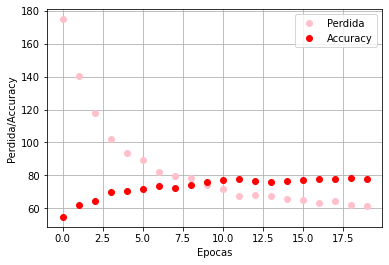

In [23]:
grafica(ww,ss)

In [32]:
estandar1 = MLP(out=256).to(device, non_blocking=True)

In [33]:
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 1e-3)

Epoca: 0   Perdida:166.9381022453308   Accuracy:58.515625
Epoca: 1   Perdida:132.80381441116333   Accuracy:62.109375
Epoca: 2   Perdida:112.37728834152222   Accuracy:66.953125
Epoca: 3   Perdida:97.82640099525452   Accuracy:70.625
Epoca: 4   Perdida:90.05602717399597   Accuracy:72.109375
Epoca: 5   Perdida:87.12334275245667   Accuracy:71.796875
Epoca: 6   Perdida:79.23082709312439   Accuracy:73.828125
Epoca: 7   Perdida:77.66408443450928   Accuracy:73.75
Epoca: 8   Perdida:76.70871257781982   Accuracy:73.828125
Epoca: 9   Perdida:72.22814440727234   Accuracy:77.1875
Epoca: 10   Perdida:70.54356813430786   Accuracy:77.34375
Epoca: 11   Perdida:65.77794075012207   Accuracy:78.046875
Epoca: 12   Perdida:66.73912167549133   Accuracy:77.265625
Epoca: 13   Perdida:66.41892194747925   Accuracy:76.25
Epoca: 14   Perdida:63.87069344520569   Accuracy:77.8125
Epoca: 15   Perdida:64.00537252426147   Accuracy:78.046875
Epoca: 16   Perdida:61.86686635017395   Accuracy:78.515625
Epoca: 17   Perdida:6

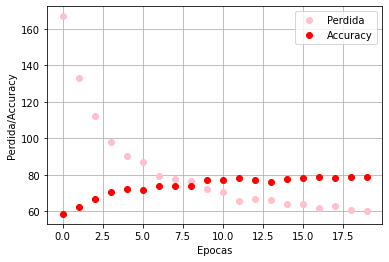

In [34]:
grafica(ww1,ss1)

In [35]:
estandar1 = MLP(out=1024).to(device, non_blocking=True)
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 1e-3)

Epoca: 0   Perdida:146.38102531433105   Accuracy:65.46875
Epoca: 1   Perdida:116.81490898132324   Accuracy:67.96875
Epoca: 2   Perdida:100.60346245765686   Accuracy:69.53125
Epoca: 3   Perdida:89.29336428642273   Accuracy:71.71875
Epoca: 4   Perdida:83.51617336273193   Accuracy:73.90625
Epoca: 5   Perdida:80.91510534286499   Accuracy:73.28125
Epoca: 6   Perdida:74.74000811576843   Accuracy:75.234375
Epoca: 7   Perdida:73.08473229408264   Accuracy:74.6875
Epoca: 8   Perdida:72.55697011947632   Accuracy:75.234375
Epoca: 9   Perdida:68.87373089790344   Accuracy:77.8125
Epoca: 10   Perdida:67.3800528049469   Accuracy:77.578125
Epoca: 11   Perdida:62.94156193733215   Accuracy:78.4375
Epoca: 12   Perdida:64.0965986251831   Accuracy:78.046875
Epoca: 13   Perdida:63.52355718612671   Accuracy:76.953125
Epoca: 14   Perdida:61.44187569618225   Accuracy:78.4375
Epoca: 15   Perdida:61.06785774230957   Accuracy:78.359375
Epoca: 16   Perdida:60.118921995162964   Accuracy:78.828125
Epoca: 17   Perdida

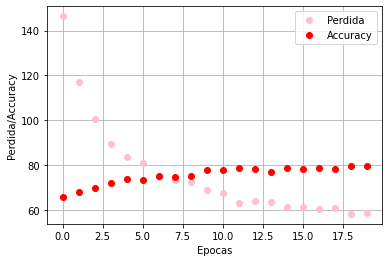

In [36]:
grafica(ww1,ss1)

In [38]:
estandar1 = MLP(out=8192).to(device, non_blocking=True)
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 1e-3)

Epoca: 0   Perdida:92.03701972961426   Accuracy:73.4375
Epoca: 1   Perdida:81.68896436691284   Accuracy:73.59375
Epoca: 2   Perdida:73.0759048461914   Accuracy:74.609375
Epoca: 3   Perdida:67.65557765960693   Accuracy:77.734375
Epoca: 4   Perdida:64.1361653804779   Accuracy:78.28125
Epoca: 5   Perdida:63.13195824623108   Accuracy:78.4375
Epoca: 6   Perdida:58.87725234031677   Accuracy:80.15625
Epoca: 7   Perdida:58.180906772613525   Accuracy:79.609375
Epoca: 8   Perdida:59.02961611747742   Accuracy:80.390625
Epoca: 9   Perdida:55.56668758392334   Accuracy:81.40625
Epoca: 10   Perdida:55.67500591278076   Accuracy:81.5625
Epoca: 11   Perdida:51.52694582939148   Accuracy:82.265625
Epoca: 12   Perdida:53.42048645019531   Accuracy:82.265625
Epoca: 13   Perdida:53.546249866485596   Accuracy:81.328125
Epoca: 14   Perdida:52.64493227005005   Accuracy:81.09375
Epoca: 15   Perdida:50.70849657058716   Accuracy:82.96875
Epoca: 16   Perdida:50.01227855682373   Accuracy:82.8125
Epoca: 17   Perdida:5

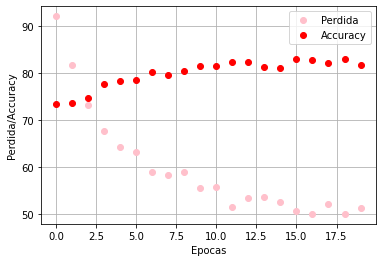

In [39]:
grafica(ww1,ss1)

In [40]:
estandar1 = MLP(out=32776).to(device, non_blocking=True)
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 1e-3)

Epoca: 0   Perdida:66.9316554069519   Accuracy:77.5
Epoca: 1   Perdida:64.59003210067749   Accuracy:77.5
Epoca: 2   Perdida:57.60757327079773   Accuracy:80.46875
Epoca: 3   Perdida:56.131219267845154   Accuracy:79.921875
Epoca: 4   Perdida:52.4487042427063   Accuracy:82.578125
Epoca: 5   Perdida:51.681437492370605   Accuracy:81.953125
Epoca: 6   Perdida:49.16002154350281   Accuracy:82.578125
Epoca: 7   Perdida:47.36085295677185   Accuracy:82.265625
Epoca: 8   Perdida:49.73921537399292   Accuracy:82.1875
Epoca: 9   Perdida:46.09479606151581   Accuracy:84.296875
Epoca: 10   Perdida:47.6501727104187   Accuracy:84.0625
Epoca: 11   Perdida:43.89891266822815   Accuracy:84.453125
Epoca: 12   Perdida:45.87796330451965   Accuracy:84.140625
Epoca: 13   Perdida:45.77449858188629   Accuracy:83.125
Epoca: 14   Perdida:45.157485008239746   Accuracy:83.75
Epoca: 15   Perdida:43.437108397483826   Accuracy:85.703125
Epoca: 16   Perdida:42.47383773326874   Accuracy:85.46875
Epoca: 17   Perdida:44.727278

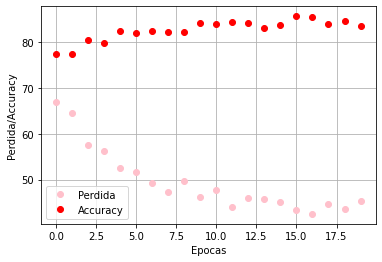

In [41]:
grafica(ww1,ss1)

In [42]:
estandar1 = MLP(out=102400).to(device, non_blocking=True)
ww1, ss1 = entrename(X = loader_train, Y = loader_test, modelo = estandar1, epocas = 20, learningRate = 1e-3)

Epoca: 0   Perdida:55.16097903251648   Accuracy:80.9375
Epoca: 1   Perdida:55.49538016319275   Accuracy:80.0
Epoca: 2   Perdida:49.57731068134308   Accuracy:82.03125
Epoca: 3   Perdida:49.516717195510864   Accuracy:82.890625
Epoca: 4   Perdida:44.779518246650696   Accuracy:84.6875
Epoca: 5   Perdida:45.10393798351288   Accuracy:83.046875
Epoca: 6   Perdida:44.63734686374664   Accuracy:83.4375
Epoca: 7   Perdida:40.61125695705414   Accuracy:84.609375
Epoca: 8   Perdida:44.37606990337372   Accuracy:83.984375
Epoca: 9   Perdida:39.321779012680054   Accuracy:86.171875
Epoca: 10   Perdida:43.01380932331085   Accuracy:85.546875
Epoca: 11   Perdida:38.84325325489044   Accuracy:86.71875
Epoca: 12   Perdida:41.399524211883545   Accuracy:85.078125
Epoca: 13   Perdida:40.58506369590759   Accuracy:85.0
Epoca: 14   Perdida:39.762245416641235   Accuracy:85.625
Epoca: 15   Perdida:38.44346880912781   Accuracy:87.421875
Epoca: 16   Perdida:37.24709630012512   Accuracy:86.796875
Epoca: 17   Perdida:39.

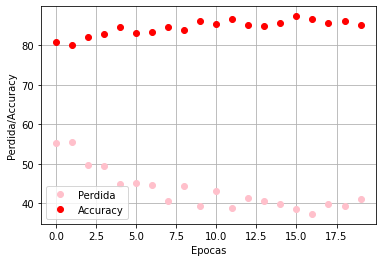

In [43]:
grafica(ww1,ss1)